<a href="https://colab.research.google.com/github/heroza/Skin-Cancer-Diagnosis/blob/main/Autoencoder_using_Skin_Cancer_Dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Prepare the dataset. 
Currently, we use skin cancer ISIC dataset from Kaggle https://www.kaggle.com/datasets/nodoubttome/skin-cancer9-classesisic

Tutorial for how to load Kaggle dataset can be found in https://www.analyticsvidhya.com/blog/2021/06/how-to-load-kaggle-datasets-directly-into-google-colab/

In [1]:
! pip install kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download nodoubttome/skin-cancer9-classesisic

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
 96% 755M/786M [00:04<00:00, 221MB/s]
100% 786M/786M [00:04<00:00, 190MB/s]


In [2]:
! unzip /content/skin-cancer9-classesisic.zip

Archive:  /content/skin-cancer9-classesisic.zip
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0010512.jpg  
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0010889.jpg  
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0024468.jpg  
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0024470.jpg  
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0024511.jpg  
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0024646.jpg  
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0024654.jpg  
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0024707.jpg  
  inflating: Ski

Load Data

In [1]:
from pathlib import Path
import os
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
def load_data(path: str):
    dir = Path(path)
    # list of all filepathes
    filepaths = list(dir.glob(r'**/*.jpg'))
    # list of labels extracted from last foldername of filepath
    labels = list(map(lambda l: os.path.split(os.path.split(l)[0])[1], filepaths))
    # series of string filepathes
    filepaths = pd.Series(filepaths, name='FilePaths').astype(str)
    # series of string labels
    labels = pd.Series(labels, name='Labels').astype(str)
    # merge series to dataframe df
    df = pd.merge(filepaths, labels, right_index=True, left_index=True)
    # Resampling complete rows and reset the index
    return df.sample(frac=1).reset_index(drop=True)


df = load_data('/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train')
X_test = load_data('/content/Skin cancer ISIC The International Skin Imaging Collaboration/Test')

In [3]:
print('Training Data: ', df.shape)
print('Test Data: ', X_test.shape)

Training Data:  (2239, 2)
Test Data:  (118, 2)


Label Distribution

[Text(0, 0, 'seborrheic keratosis'),
 Text(0, 0, 'dermatofibroma'),
 Text(0, 0, 'actinic keratosis'),
 Text(0, 0, 'vascular lesion'),
 Text(0, 0, 'squamous cell carcinoma'),
 Text(0, 0, 'nevus'),
 Text(0, 0, 'basal cell carcinoma'),
 Text(0, 0, 'melanoma'),
 Text(0, 0, 'pigmented benign keratosis')]

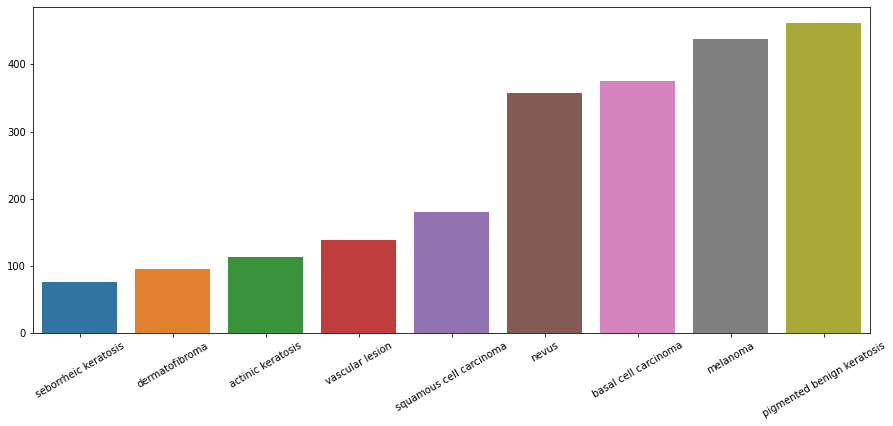

In [4]:
# ordered count of rows per unique label
labels_count = df['Labels'].value_counts(ascending=True)

f = plt.figure(figsize=(15, 6))
s = sns.barplot(x=labels_count.index,y=labels_count.values)
s.set_xticklabels(s.get_xticklabels(), rotation = 30)

Plot 3 images per label

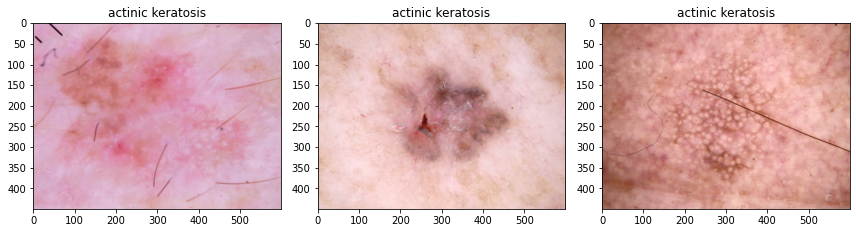

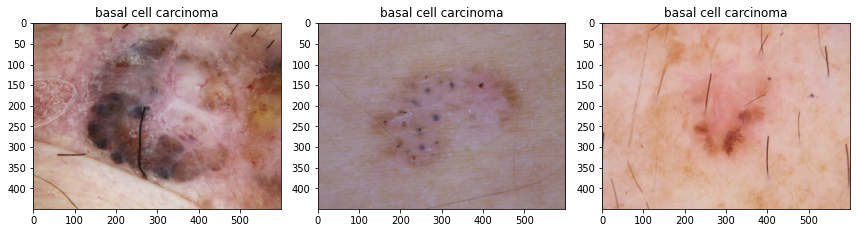

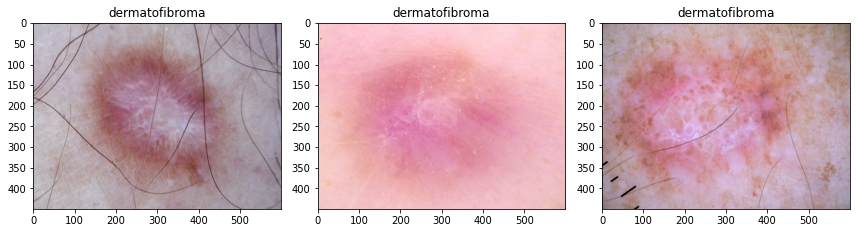

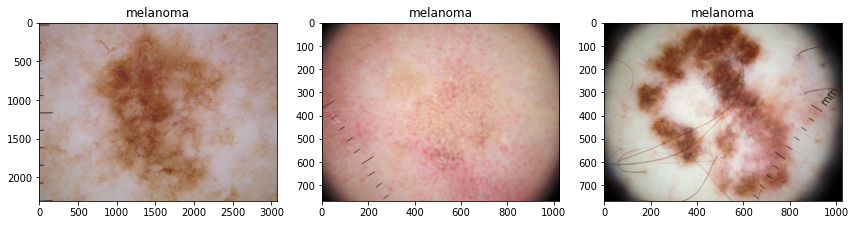

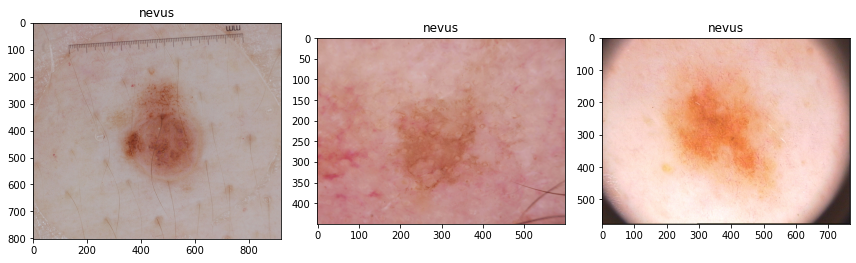

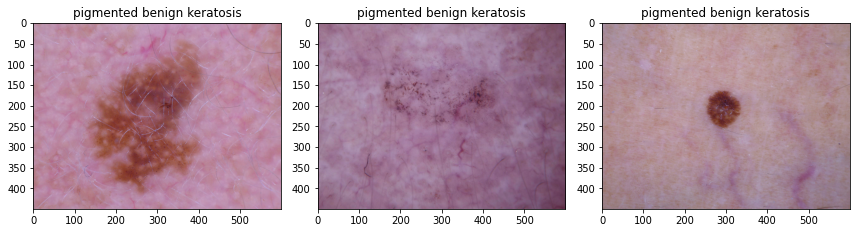

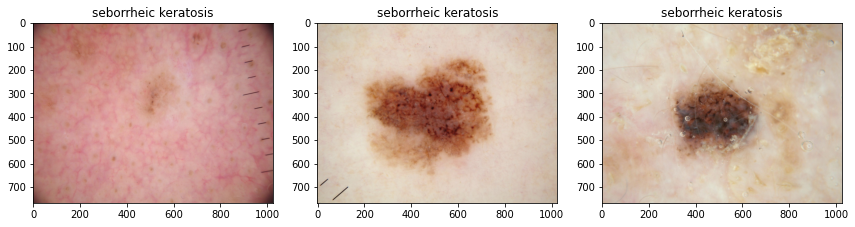

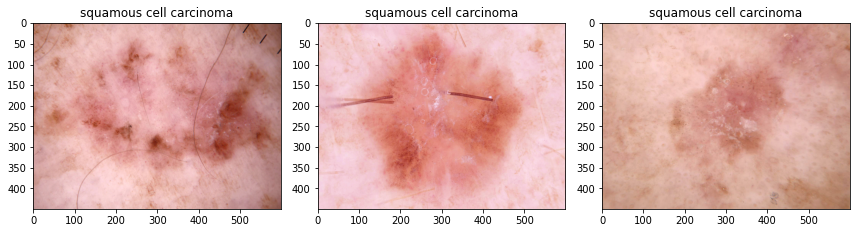

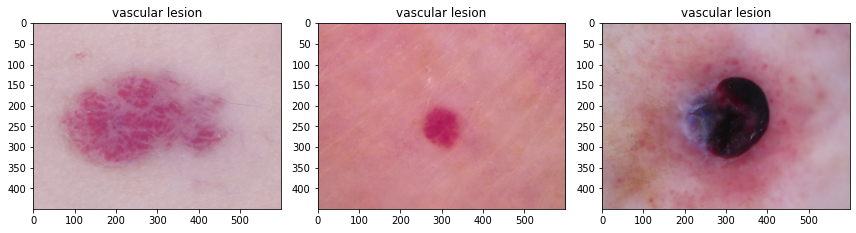

In [5]:
def plot_images_per_label(df, label, cols: int, size: tuple):
    fig, axs = plt.subplots(nrows=1, ncols=cols, figsize=size)

    cntMax = cols
    cntCur = 0
    for index, row in df.iterrows():
        if(row['Labels'] == label and cntCur < cntMax):
            axs[cntCur].imshow(plt.imread(df.FilePaths[index]))
            axs[cntCur].set_title(df.Labels[index])

            cntCur += 1
        else:
            if(cntCur >= cntMax):
                break
    
    plt.tight_layout()
    plt.show()


# unique labels
labels = sorted(df['Labels'].unique())
# loop through labels
for label in labels:
    plot_images_per_label(df, label, 3, (12,9))

References: 
*   https://www.tensorflow.org/tutorials/generative/autoencoder
*   https://stackabuse.com/autoencoders-for-image-reconstruction-in-python-and-keras/


Basic Autoencoder

In [6]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses
from tensorflow.keras.models import Model

In [7]:
latent_dim = 1000 

class Autoencoder(Model):
  def __init__(self, latent_dim):
    super(Autoencoder, self).__init__()
    self.latent_dim = latent_dim   
    self.encoder = tf.keras.Sequential([
      layers.Flatten(),
      layers.Dense(latent_dim, activation='relu'),
    ])
    self.decoder = tf.keras.Sequential([
      layers.Dense(256*256*3, activation='sigmoid'),
      layers.Reshape((256, 256, 3))
    ])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded
  
autoencoder = Autoencoder(latent_dim) 

In [8]:
autoencoder.compile(optimizer='adam', loss=losses.MeanSquaredError())

In [9]:
y = df['Labels']
X = df.drop('Labels', 1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  


In [10]:
# input image size
IMAGE_W = 256
IMAGE_H = 256
IMG_SIZE = (IMAGE_W,IMAGE_H)

In [11]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array
X_train = []
for img in X['FilePaths']:
    loaded_img = load_img(img, target_size=IMG_SIZE)
    img_arr = img_to_array(loaded_img)
    X_train.append(img_arr)

X_train = np.array(X_train)
X_train = X_train.astype('float32') / 255.
print(np.array(X_train).shape)

(2239, 256, 256, 3)


In [12]:
X_test_arr = []
for img in X_test['FilePaths']:
    loaded_img = load_img(img, target_size=IMG_SIZE)
    img_arr = img_to_array(loaded_img)
    X_test_arr.append(img_arr)
    
y_test = X_test['Labels']
X_test = X_test_arr
X_test = np.array(X_test)
X_test = X_test.astype('float32') / 255.
print(np.array(X_test_arr).shape)  

(118, 256, 256, 3)


In [14]:
history = autoencoder.fit(X_train, X_train,
                epochs=20,
                shuffle=True,
                validation_data=(X_test, X_test))

Epoch 1/20
70/70 [==============================] - 11s 114ms/step - loss: 0.0214 - val_loss: 0.0206
Epoch 2/20
70/70 [==============================] - 8s 111ms/step - loss: 0.0133 - val_loss: 0.0165
Epoch 3/20
70/70 [==============================] - 8s 112ms/step - loss: 0.0123 - val_loss: 0.0166
Epoch 4/20
70/70 [==============================] - 8s 112ms/step - loss: 0.0122 - val_loss: 0.0150
Epoch 5/20
70/70 [==============================] - 8s 112ms/step - loss: 0.0117 - val_loss: 0.0146
Epoch 6/20
70/70 [==============================] - 8s 111ms/step - loss: 0.0116 - val_loss: 0.0148
Epoch 7/20
70/70 [==============================] - 8s 111ms/step - loss: 0.0113 - val_loss: 0.0144
Epoch 8/20
70/70 [==============================] - 8s 112ms/step - loss: 0.0110 - val_loss: 0.0159
Epoch 9/20
70/70 [==============================] - 8s 111ms/step - loss: 0.0109 - val_loss: 0.0139
Epoch 10/20
70/70 [==============================] - 8s 111ms/step - loss: 0.0112 - val_loss: 0.015

In [15]:
print(autoencoder.summary())

Model: "autoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 1000)              196609000 
                                                                 
 sequential_1 (Sequential)   (None, 256, 256, 3)       196804608 
                                                                 
Total params: 393,413,608
Trainable params: 393,413,608
Non-trainable params: 0
_________________________________________________________________
None


In [16]:
encoded_imgs = autoencoder.encoder(X_test).numpy()
decoded_imgs = autoencoder.decoder(encoded_imgs).numpy()

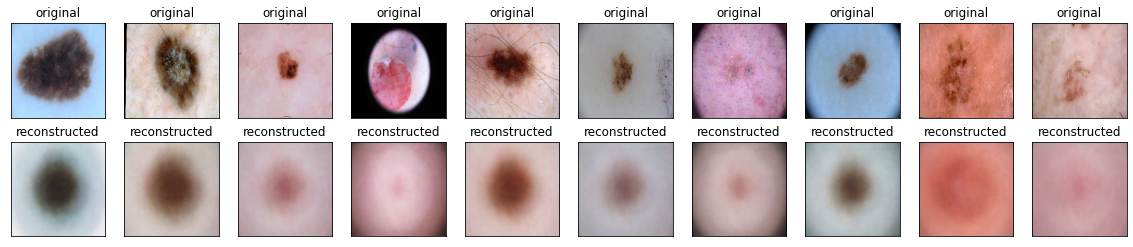

In [17]:
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
  # display original
  ax = plt.subplot(2, n, i + 1)
  plt.imshow(X_test[i])
  plt.title("original")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

  # display reconstruction
  ax = plt.subplot(2, n, i + 1 + n)
  plt.imshow(decoded_imgs[i])
  plt.title("reconstructed")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
plt.show()

Loss over epoch

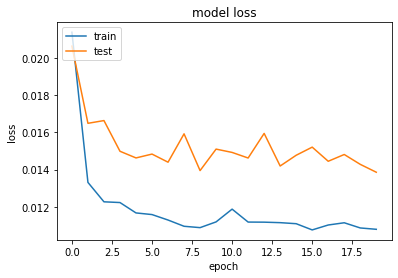

In [18]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

Image denoising

In [21]:
noise_factor = 0.2
x_train_noisy = X_train + noise_factor * tf.random.normal(shape=X_train.shape) 
x_test_noisy = X_test + noise_factor * tf.random.normal(shape=X_test.shape) 

x_train_noisy = tf.clip_by_value(x_train_noisy, clip_value_min=0., clip_value_max=1.)
x_test_noisy = tf.clip_by_value(x_test_noisy, clip_value_min=0., clip_value_max=1.)

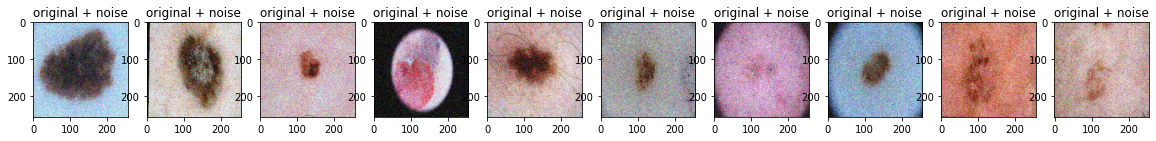

In [22]:
n = 10
plt.figure(figsize=(20, 2))
for i in range(n):
    ax = plt.subplot(1, n, i + 1)
    plt.title("original + noise")
    plt.imshow(tf.squeeze(x_test_noisy[i]))
    plt.gray()
plt.show()

In [23]:
class Denoise(Model):
  def __init__(self):
    super(Denoise, self).__init__()
    self.encoder = tf.keras.Sequential([
      layers.Input(shape=(256, 256, 3)),
      layers.Conv2D(16, (3, 3), activation='relu', padding='same', strides=2),
      layers.Conv2D(8, (3, 3), activation='relu', padding='same', strides=2)])

    self.decoder = tf.keras.Sequential([
      layers.Conv2DTranspose(8, kernel_size=3, strides=2, activation='relu', padding='same'),
      layers.Conv2DTranspose(16, kernel_size=3, strides=2, activation='relu', padding='same'),
      layers.Conv2D(3, kernel_size=(3, 3), activation='sigmoid', padding='same')])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

autoencoder = Denoise()